# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 14 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import sklearn.manifold
import sklearn.metrics
%matplotlib inline

print ('start')
listOfBusinesses = []
with open ('yelp_academic_dataset_business.json') as file:
    for x in file:
        listOfBusinesses.append(json.loads(x))

coords = []
restaurants = []
categories = []
temp = ''
categoryList = []

for x in listOfBusinesses:
    if x['state'] == 'NV' and 'Restaurants' in x['categories']:
        coords.append([x['latitude'],x['longitude']])
        restaurants.append(x['business_id'])
        for i in x['categories']:
            if (i != 'Food' and i !='Restaurants'):
                categoryList.append(i)
        categories.append([i for i in x['categories'] if (i != 'Food' and i !='Restaurants')])

categoryList = np.asarray(categoryList)

df = pd.DataFrame(categoryList, columns=['Category'])
top15Categories = (df['Category'].value_counts().to_frame().reset_index())[0:15]
# print (top15Categories)

temp = []
featMatrix = []
add = False
updatedRestaurants = []
myCoords = []
for x in range(len(categories)):
    for y in top15Categories['index']:
        if (y in categories[x]):
            temp.append(1)
            add = True
        else:
            temp.append(0)
    myCoords.append(([coords[x][0]*.005,(coords[x][1]*-.005)]))
    if add:
        featMatrix.append(temp)
        updatedRestaurants.append(restaurants[x])

    add = False
    temp = []
cols = [x for x in top15Categories['index']]
# cols.append('lat')
# cols.append('long')
finalDF = pd.DataFrame(data=featMatrix,index=updatedRestaurants,columns=cols).transpose()
# print (finalDF)

featMatrix =  np.asarray(featMatrix)
print ('done')

start
done


In [80]:
print (top15Categories)

                     index  Category
0                Fast Food       812
1                  Mexican       679
2   American (Traditional)       587
3                    Pizza       582
4               Sandwiches       533
5                Nightlife       516
6                     Bars       488
7                  Burgers       425
8                  Chinese       411
9           American (New)       384
10                 Italian       336
11                Japanese       288
12      Breakfast & Brunch       248
13                 Seafood       212
14              Sushi Bars       212


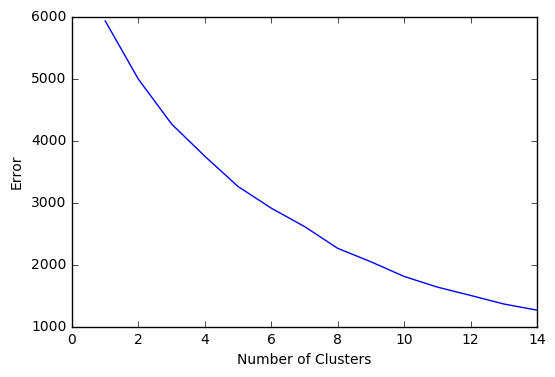

In [3]:
error = np.zeros(15)
error[0]=0
for k in range(1,15):
    kmeans = KMeans(init='k-means++',n_clusters=k, n_init=100)
    kmeans.fit_predict(featMatrix, y=myCoords)
    error[k] = kmeans.inertia_
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of Clusters')
plt.ylabel('Error')


The amount of error appears to be stabilizing around 14 clusters, so I will use 14 clusters for my kMeans algorithm.

In [74]:
kmeans = KMeans(init='k-means++',n_clusters=14, n_init=100)
kmeans.fit_predict(featMatrix, y=myCoords)
labels = kmeans.labels_
clusters = kmeans.cluster_centers_

print (clusters)

[[  1.00000000e+00   1.05471187e-15   7.49400542e-16   2.55754476e-03
    4.24552430e-01  -8.74300632e-16   6.66133815e-16  -5.41233725e-16
    0.00000000e+00  -5.55111512e-17   2.55754476e-03   7.67263427e-03
    3.33066907e-16   1.11022302e-16   1.11022302e-16]
 [  2.42424242e-02   1.09090909e-01   1.15151515e-01  -1.94289029e-16
    1.80411242e-16   6.06060606e-03   4.44089210e-16   6.06060606e-03
    0.00000000e+00   7.27272727e-02   6.06060606e-02   1.11022302e-16
   -1.38777878e-17   1.00000000e+00   2.42424242e-02]
 [  4.44089210e-16   4.16333634e-16   1.00000000e+00   1.87500000e-02
    1.80411242e-16   1.00000000e+00   9.93750000e-01   7.50000000e-02
    0.00000000e+00   3.12500000e-02   6.25000000e-03   9.71445147e-17
    1.25000000e-02   6.25000000e-03  -9.71445147e-17]
 [  7.03517588e-02   5.02512563e-03   7.53768844e-03   1.19348975e-15
    1.94289029e-16   2.51256281e-03   6.66133815e-16  -5.55111512e-16
    1.00000000e+00   5.02512563e-03   2.51256281e-03   3.01507538e-0

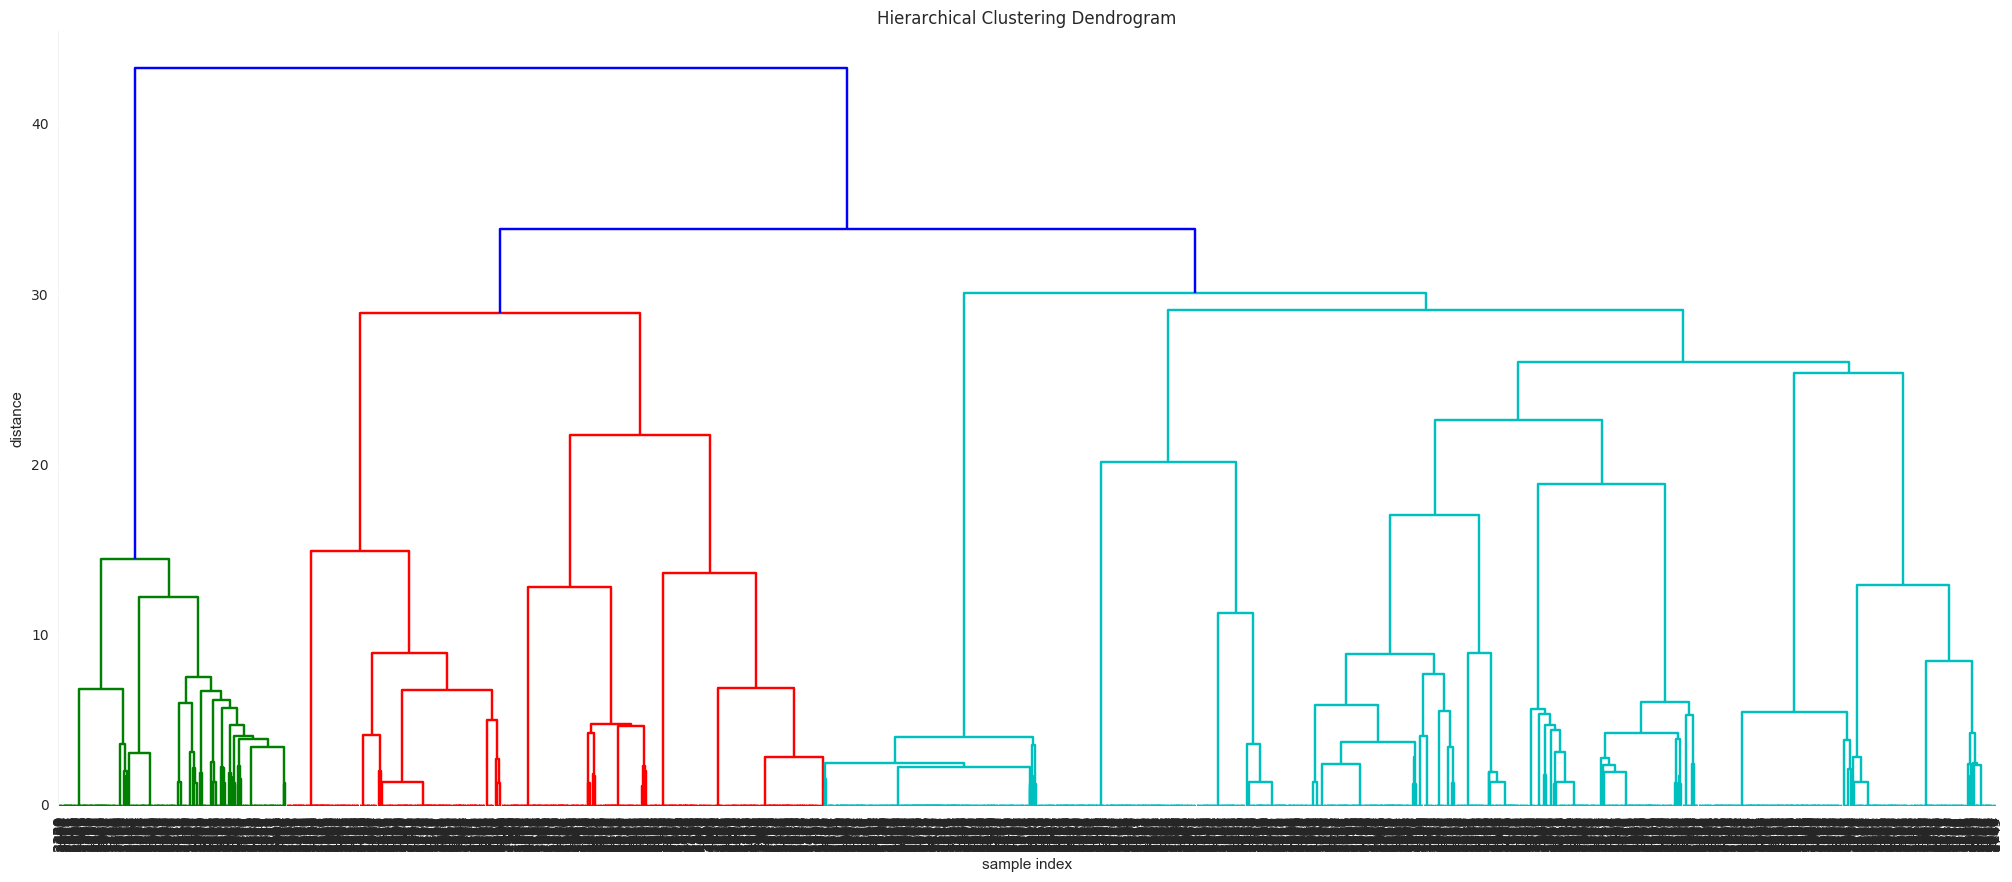

In [60]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

myCatsAndCoords = []
for i in range(len(featMatrix)):
    temp = (np.concatenate((featMatrix[i],myCoords[i])))
    myCatsAndCoords.append(temp)
cc = pd.DataFrame(myCatsAndCoords)
linkageMatrix = linkage(cc, 'ward')

# print (linkageMatrix)

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkageMatrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)
plt.show()


In [40]:
from scipy.cluster.hierarchy import fcluster
fcluster(linkageMatrix, 14, depth=10)

array([2, 7, 6, ..., 2, 6, 8], dtype=int32)

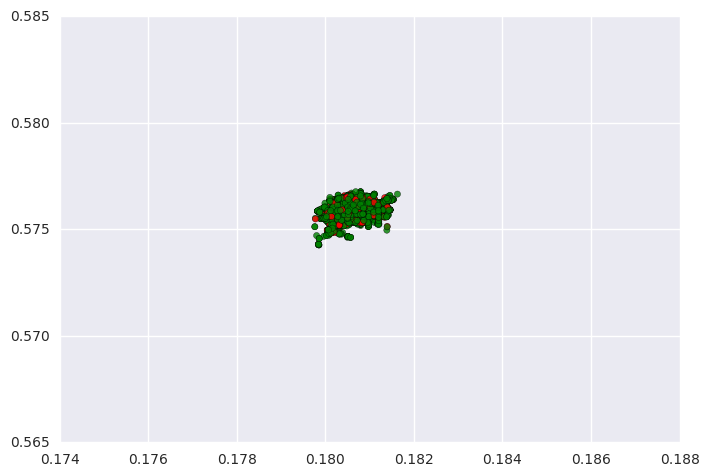

In [64]:
import seaborn as sns
from sklearn import mixture

gmix = mixture.GMM(n_components=4, covariance_type='full')
gmix.fit(cc)
# print gmix.means_
colors = ['r' if i==0 else 'g' for i in gmix.predict(cc)]
ax = plt.gca()
ax.scatter(cc.loc[:,15], cc.loc[:,16], c=colors, alpha=0.8)
plt.show()

I chose 4 components for the GMM algorithm because the heirarchical algorithm showed us four clusters.

Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

here


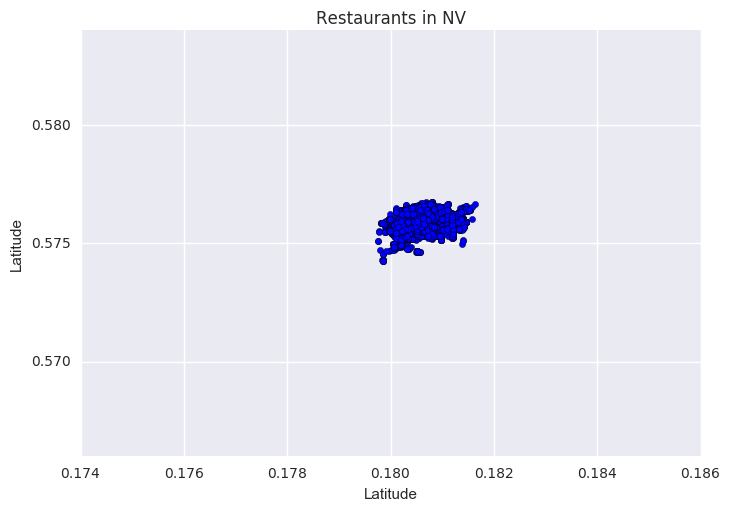

In [68]:
plt.title('Restaurants in NV')
for x in myCoords:
    plt.scatter(x[0],x[1])
    
plt.xlabel('Latitude')
plt.ylabel('Latitude')
print ('here')

<function matplotlib.pyplot.show>

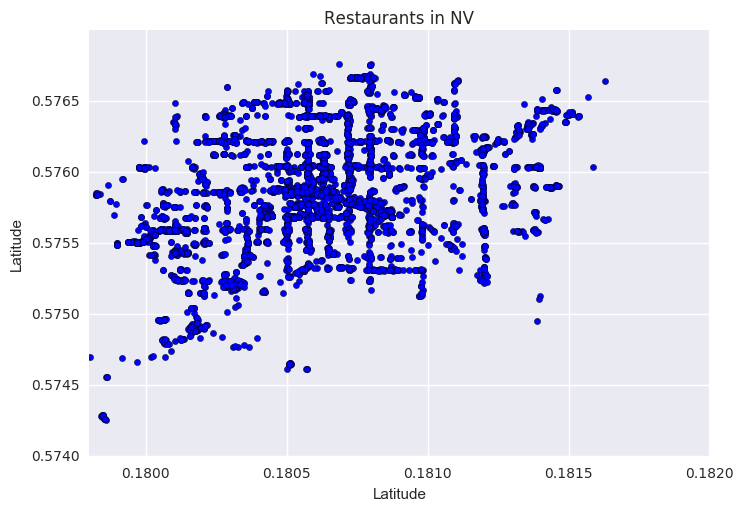

In [72]:
plt.axis([.1798,.182,.574,.577])
plt.title('Restaurants in NV')
for x in myCoords:
    plt.scatter(x[0],x[1])

plt.xlabel('Latitude')
plt.ylabel('Latitude')
plt.show

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

The more exotic foods and high end foods tend to be found together while some of the less common cuisines tend to become the outliers.

Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

Not surprisingly in a big city, the most common category is fast food which is spread out through the city. We can see that the night life category is clustered more towards the center of town because that is where most people tend to go out. 

----------